# Laboratorium 1


### Konfiguracja

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
import json as js
import math
import random
from scipy.stats import linregress


TEN_TO_FIVE = int(math.pow(10, 5))
TEN_TO_FOURTEEN = int(math.pow(10, 14))

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [36]:
class PointsCollection:
    def __init__(self, points = [], color = None, marker = None):
        self.points = np.array(points)
        self.color = color
        self.marker = marker
        
class LinesCollection:
    def __init__(self, lines = [], color = None):
        self.color = color
        self.lines = lines
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        if self.color:
            return mcoll.LineCollection(self.lines, [mcolors.to_rgba(self.color)] * len(self.lines))
        else:
            return mcoll.LineCollection(self.lines)

class Plot:
    def __init__(self, points=[], lines=[], json = None):
        if json is None:
            self.points = points
            self.lines = lines
        else:
            self.points = [PointsCollection(pointsCol) for pointsCol in js.loads(json)["points"]]
            self.lines = [LinesCollection(linesCol) for linesCol in js.loads(json)["lines"]]
            
    def draw(self):
        plt.close()
        ax = plt.axes()
        for collection in self.points:
            if collection.points.size > 0:
                ax.scatter(*zip(*collection.points), c=collection.color, marker=collection.marker)
        for collection in self.lines:
            ax.add_collection(collection.get_collection())
        ax.autoscale()
        plt.draw()
        
    def toJSON(self):
        return js.dumps({"points": [pointCol.points.tolist() for pointCol in self.points], 
                          "lines":[linesCol.lines for linesCol in self.lines]})

### Przykład użycia

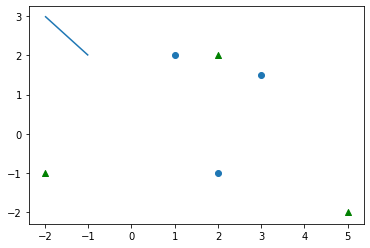

In [37]:
%matplotlib inline

plot = Plot([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
             PointsCollection([(5, -2), (2, 2), (-2, -1)], color = 'green', marker = "^")], 
            [LinesCollection([[(-1,2),(-2,3)]])])
plot.draw()


### Rozwiązanie

#### Funkcje słóżące do generowania list losowych punktów
Funkcja losująca punkty została zaprojektowana w taki sposób, aby generator punktu losowego można było przekazać jako arguemnt. Pozwala to na implementację różnych generatorów punktu spełniających odpowiednia kowencję tj. przyjmujących dwa argumenty typu krotka na wejście. Zaimplementowałem następujące generatory punktu:
1. generator punktu losowego, jako argumenty podajemy zakres współżędnej x oraz zakres współżędnej y
2. generator punktu losowego na okręgu, jako argument podajemy zakres kąta(na jakim wycinku koła chcemy losowapunktu),    oraz zakres promienia w jakim maja być punkty od punktu (0,0)
3. generator punktu losowego na lini, jako argument podajmey krotkę skądająca się z współczynnika kierunkowego prostej oraz jej przesunięcia, oraz krotkę wyrażającą zakres w jakim maja znaleźć się obie współżędne losowanego punktu.

In [38]:
def generate_random_point(range_a, range_b):
    return random.uniform(range_a[0], range_a[1]),random.uniform(range_b[0], range_b[1])

def generate_point_on_circle(angle_range, radius_range):
    angle = random.uniform(angle_range[0], angle_range[1])
    radius = random.uniform(radius_range[0], radius_range[1])
    return math.cos(angle)*radius, math.sin(angle)*radius

def generate_point_on_line(slope_intercept, range_x_y):
    slope = slope_intercept[0]
    intercept = slope_intercept[1]
    A = range_x_y[0]
    B = range_x_y[1]
    if slope < 0:
        new_A = (B-intercept)/slope
        new_B = (A-intercept)/slope
    if slope > 0:
        new_A = (A-intercept)/slope
        new_B = (B-intercept)/slope
    
    if new_A > A:
        A = new_A
    if new_B < B:
        B = new_B
    x = random.uniform(A, B)
    return x, slope*x+intercept

def generate_array_of_random_points(n, range_x, range_y=None, generator=generate_random_point):
    points = []
    if range_y is None:
        range_y = range_x
    for i in range(0, n):
        points.append(generator(range_x, range_y))
    return points


#### a) 10^5 losowych punktów o współrzędnych z przedziału [-1000, 1000]

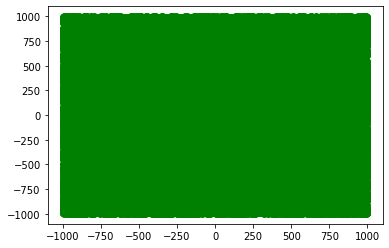

In [39]:
%matplotlib inline

points_1 = generate_array_of_random_points(TEN_TO_FIVE,(-1000,1000))
plot1 = Plot([PointsCollection(points_1, color="green")])
plot1.draw()

#### b) 10^5 losowych punktów o współrzędnych z przedziału [-10^14, 10^14], 

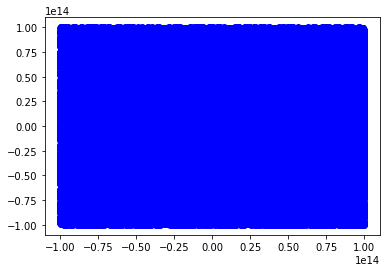

In [40]:
points_2 = generate_array_of_random_points(TEN_TO_FIVE,((-1)*TEN_TO_FOURTEEN,TEN_TO_FOURTEEN))
plot2 = Plot([PointsCollection(points_2, color="blue")])
plot2.draw()

#### c) 1000 losowych punktów leżących na okręgu o środku (0,0) i promieniu R=100, 

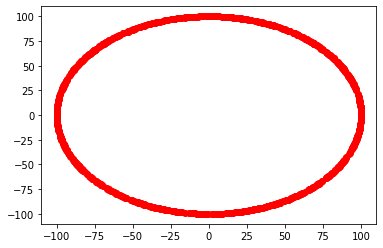

In [41]:
%matplotlib inline

points_3 = generate_array_of_random_points(1000,(0,2*math.pi),(100,100), generate_point_on_circle)
plot3 = Plot([PointsCollection(points_3, color="red")])
plot3.draw()

#### d) 1000 losowych punktów o współrzędnych z przedziału [-1000, 1000] leżących na prostej wyznaczonej przez wektor (a, b), przyjmij a = [-1.0, 0.0], b = [1.0, 0.1]

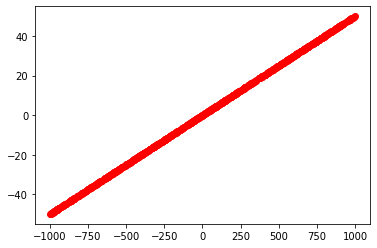

In [42]:
%matplotlib inline

slope, intercept, r_value, p_value, std_err = linregress([-1,1],[0,0.1])
points_4 = generate_array_of_random_points(1000,(slope,intercept),(-1000,1000), generate_point_on_line)
plot4 = Plot([PointsCollection(points_4, color="red")])
plot4.draw()

### Klasyfikacja punktów względem prostej opartej na punktach A, B

#### Funkcje wyliczające wyznaczniki i klasyfikator punktów

In [43]:
# [(ax,ay),(bx,by)] = array
def det_ev(array):
    if len(array) == 2:
        return array[0][0]*array[1][1]-array[1][0]*array[0][1]
    if len(array) == 3:
        return (array[0][0]*array[1][1] + array[1][0]*array[2][1] + array[2][0]*array[0][1])-(array[2][0]*array[1][1] + array[0][0]*array[2][1] + array[1][0]*array[0][1])

def numpy_det(array):
    return np.linalg.det(np.array(array))

def generate_matrix_3x3(point, point_a, point_b):
    matrix = [[point_a[0], point_a[1],1], [point_b[0], point_b[1],1], [point[0], point[1],1]]
    return matrix
def generate_matrix_2x2(point, point_a, point_b):
    matrix = [[point_a[0]-point[0], point_a[1]-point[1]], [point_b[0]-point[0], point_b[1]-point[1]]]
    return matrix

def classify_point(point, point_a, point_b, epsilon, matrix_generator, det):
    determinant = det(matrix_generator(point, point_a, point_b))
    if abs(determinant) > epsilon:
        if determinant < 0:
            return -1
        else:
            return 1
    if abs(determinant) < epsilon:
        return 0
    
    
def classify_points(points,epsilon, matrix_generator = generate_matrix_2x2, det_evaluator = det_ev, point_a = (-1.0, 0.0), point_b = (1.0, 0.1), color_over='green', color_under='blue', color_on_line="red"):
    points_over = []
    points_on_line = []
    points_under = []
    for point in points:
        point_class = classify_point(point, point_a, point_b, epsilon, matrix_generator, det_evaluator)
        if point_class > 0:
            points_over.append(point)
        if point_class < 0:
            points_under.append(point)
        if point_class == 0:
            points_on_line.append(point)
    
    return PointsCollection(points_over, color=color_over),PointsCollection(points_on_line, color=color_on_line),PointsCollection(points_under, color=color_under)

#### Wykresy dla pierwszego zbioru punktow:
 
1. epsilon = 0.01
  

a) macierz 2x2

Dla wyznacznika liczonego ze wzoru:

Pod linią:  50047
Na lini:  0
Nad linią:  49953


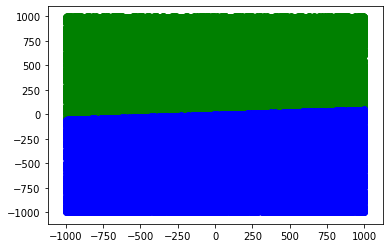

In [44]:
%matplotlib inline

classified_points = classify_points(points_1, 0.01)
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [45]:
classified_points = classify_points(points_1, 0.01,det_evaluator=numpy_det)

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Pod linią:  50047
Na lini:  0
Nad linią:  49953


a) macierz 3x3

Pod linią:  50047
Na lini:  0
Nad linią:  49953


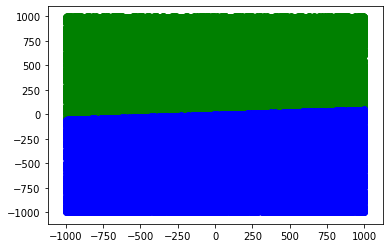

In [46]:
%matplotlib inline

classified_points = classify_points(points_1, 0.01, generate_matrix_3x3)
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [47]:
classified_points = classify_points(points_1, 0.01,generate_matrix_3x3,det_evaluator=numpy_det)

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Pod linią:  50047
Na lini:  0
Nad linią:  49953


2. epsilon = 0.1 

a) macierz 2x2

Pod linią:  50046
Na lini:  2
Nad linią:  49952


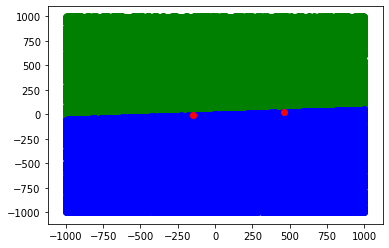

In [48]:
%matplotlib inline

classified_points = classify_points(points_1, 0.1)
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [49]:
classified_points = classify_points(points_1, 0.1,det_evaluator=numpy_det)

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Pod linią:  50046
Na lini:  2
Nad linią:  49952


a) macierz 3x3

Pod linią:  50046
Na lini:  2
Nad linią:  49952


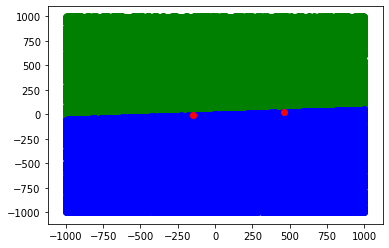

In [50]:
%matplotlib inline

classified_points = classify_points(points_1, 0.1,generate_matrix_3x3)
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [51]:
classified_points = classify_points(points_1, 0.1,generate_matrix_3x3,det_evaluator=numpy_det)

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Pod linią:  50046
Na lini:  2
Nad linią:  49952


3. epsilon = 1

a) macierz 2x2

Pod linią:  50031
Na lini:  48
Nad linią:  49921


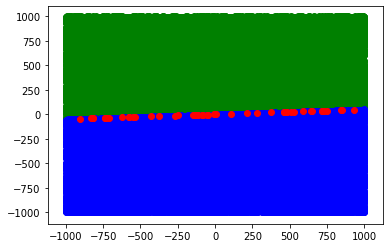

In [52]:
%matplotlib inline

classified_points = classify_points(points_1, 1)
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [53]:
classified_points = classify_points(points_1, 1,det_evaluator=numpy_det)

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Pod linią:  50031
Na lini:  48
Nad linią:  49921


a) macierz 3x3

Pod linią:  50031
Na lini:  48
Nad linią:  49921


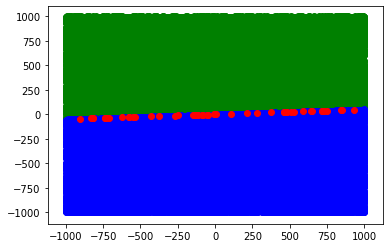

In [54]:
%matplotlib inline

classified_points = classify_points(points_1, 1,generate_matrix_3x3)
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [55]:
classified_points = classify_points(points_1, 1,generate_matrix_3x3,det_evaluator=numpy_det)

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Pod linią:  50031
Na lini:  48
Nad linią:  49921


4. epsilon = 10

a) macierz 2x2

Pod linią:  49790
Na lini:  497
Nad linią:  49713


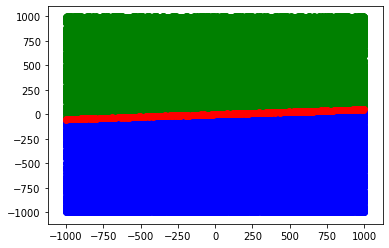

In [56]:
%matplotlib inline

classified_points = classify_points(points_1, 10)
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [57]:
classified_points = classify_points(points_1, 10,det_evaluator=numpy_det)

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Pod linią:  49790
Na lini:  497
Nad linią:  49713


a) macierz 3x3

Pod linią:  49790
Na lini:  497
Nad linią:  49713


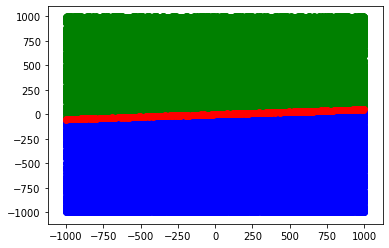

In [58]:
%matplotlib inline

classified_points = classify_points(points_1, 10,generate_matrix_3x3)
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [59]:
classified_points = classify_points(points_1, 10,generate_matrix_3x3,det_evaluator=numpy_det)

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Pod linią:  49790
Na lini:  497
Nad linią:  49713


#### Wykres dla drugiego zbioru punktow

1. epsilon = 0.1 

a) macierz 2x2

Pod linią:  50093
Na lini:  5
Nad linią:  49902


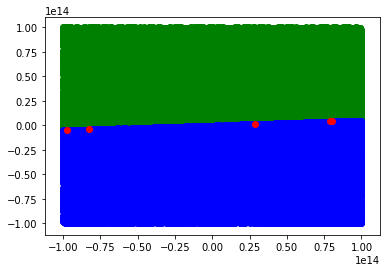

In [60]:
%matplotlib inline

classified_points = classify_points(points_2, 0.1)
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [61]:
classified_points = classify_points(points_2, 0.1,det_evaluator=numpy_det)

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Pod linią:  50094
Na lini:  0
Nad linią:  49906


b) macierz 3x3

Pod linią:  50097
Na lini:  0
Nad linią:  49903


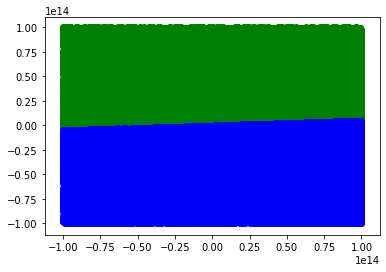

In [62]:
%matplotlib inline

classified_points = classify_points(points_2, 0.1,generate_matrix_3x3)
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [63]:
classified_points = classify_points(points_2, 0.1,generate_matrix_3x3,det_evaluator=numpy_det)

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Pod linią:  50097
Na lini:  0
Nad linią:  49903


2. epsilon = 10^5

a) macierz 2x2

Pod linią:  50093
Na lini:  5
Nad linią:  49902


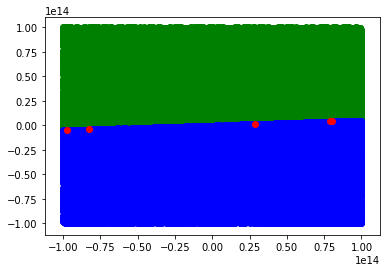

In [64]:
%matplotlib inline

classified_points = classify_points(points_2, math.pow(10,5))
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [65]:
classified_points = classify_points(points_2, math.pow(10,5),det_evaluator=numpy_det)

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Pod linią:  50094
Na lini:  0
Nad linią:  49906


b) macierz 3x3

Pod linią:  50097
Na lini:  0
Nad linią:  49903


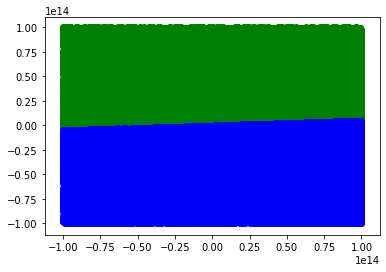

In [66]:
%matplotlib inline

classified_points = classify_points(points_2, math.pow(10,5),generate_matrix_3x3)
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [67]:
classified_points = classify_points(points_2,math.pow(10,5),generate_matrix_3x3,det_evaluator=numpy_det)

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Pod linią:  50097
Na lini:  0
Nad linią:  49903


3. epsilon = 10^12 

a) macierz 2x2

Pod linią:  49877
Na lini:  461
Nad linią:  49662


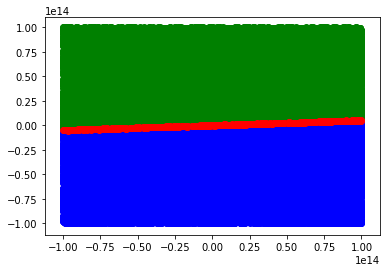

In [68]:
%matplotlib inline

classified_points = classify_points(points_2, math.pow(10,12))
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [69]:
classified_points = classify_points(points_2, math.pow(10,12),det_evaluator=numpy_det)

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Pod linią:  49878
Na lini:  459
Nad linią:  49663


b) macierz 3x3

Pod linią:  49878
Na lini:  460
Nad linią:  49662


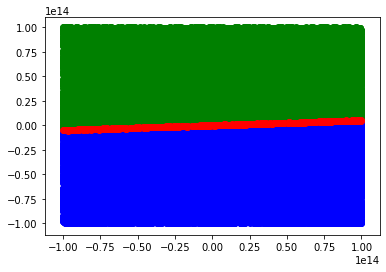

In [70]:
%matplotlib inline

classified_points = classify_points(points_2, math.pow(10,12),generate_matrix_3x3)
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [71]:
classified_points = classify_points(points_2,math.pow(10,12),generate_matrix_3x3, det_evaluator=numpy_det)

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Pod linią:  49878
Na lini:  460
Nad linią:  49662


#### Wykres dla  zbioru punktow na okregu

1. epsilon = 0.1 

a) macierz 2x2

Pod linią:  489
Na lini:  0
Nad linią:  511


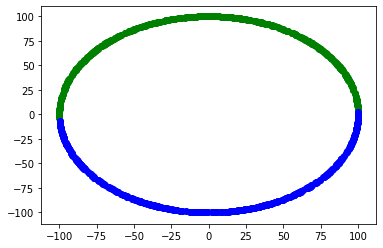

In [72]:
%matplotlib inline

classified_points = classify_points(points_3, 0.1)
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [73]:
classified_points = classify_points(points_3, 0.1,det_evaluator=numpy_det)

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Pod linią:  489
Na lini:  0
Nad linią:  511


b) macierz 3x3

Pod linią:  489
Na lini:  0
Nad linią:  511


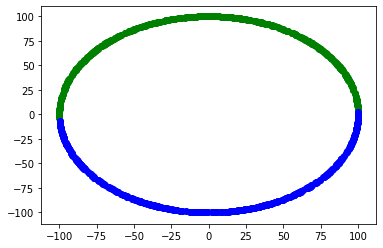

In [74]:
%matplotlib inline

classified_points = classify_points(points_3, 0.1,generate_matrix_3x3)
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [75]:
classified_points = classify_points(points_3,0.1,generate_matrix_3x3,det_evaluator=numpy_det)

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Pod linią:  489
Na lini:  0
Nad linią:  511


2. epsilon = 5

a) macierz 2x2

Pod linią:  484
Na lini:  7
Nad linią:  509


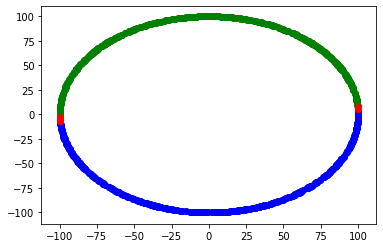

In [76]:
%matplotlib inline

classified_points = classify_points(points_3, 5)
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [77]:
classified_points = classify_points(points_2, 5,det_evaluator=numpy_det)

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Pod linią:  50094
Na lini:  0
Nad linią:  49906


b) macierz 3x3

Pod linią:  484
Na lini:  7
Nad linią:  509


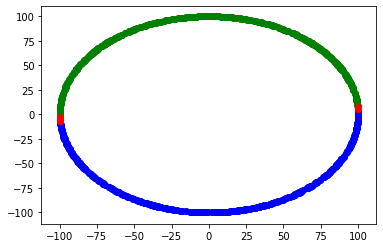

In [78]:
%matplotlib inline

classified_points = classify_points(points_3, 5,generate_matrix_3x3)
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [79]:
classified_points = classify_points(points_3,5,generate_matrix_3x3, det_evaluator=numpy_det)

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Pod linią:  484
Na lini:  7
Nad linią:  509


2. epsilon = 10

a) macierz 2x2

Pod linią:  467
Na lini:  32
Nad linią:  501


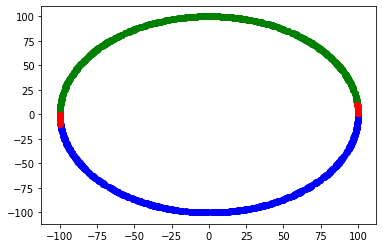

In [80]:
%matplotlib inline

classified_points = classify_points(points_3, 10)
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [81]:
classified_points = classify_points(points_3, 10, det_evaluator=numpy_det)

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Pod linią:  467
Na lini:  32
Nad linią:  501


b) macierz 3x3

Pod linią:  467
Na lini:  32
Nad linią:  501


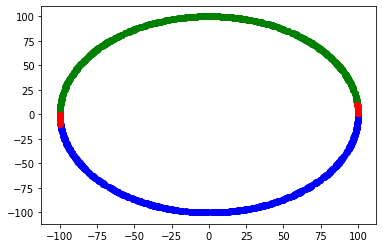

In [82]:
%matplotlib inline

classified_points = classify_points(points_3, 10,generate_matrix_3x3)
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [83]:
classified_points = classify_points(points_3,10,generate_matrix_3x3, det_evaluator=numpy_det)

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Pod linią:  467
Na lini:  32
Nad linią:  501


#### Wykres dla  zbioru punktow na prostej

1. epsilon = 10^(-5)

a) macierz 2x2

Pod linią:  0
Na lini:  1000
Nad linią:  0


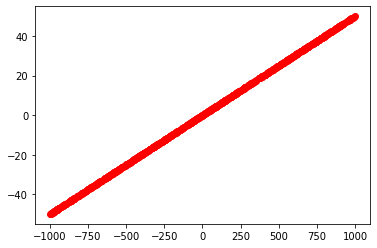

In [84]:
%matplotlib inline

classified_points = classify_points(points_4, 0.00001)
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [85]:
classified_points = classify_points(points_4,0.00001, det_evaluator=numpy_det)

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Pod linią:  0
Na lini:  1000
Nad linią:  0


b) macierz 3x3

Pod linią:  0
Na lini:  1000
Nad linią:  0


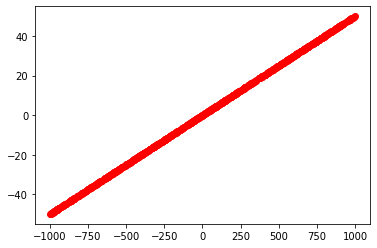

In [86]:
%matplotlib inline

classified_points = classify_points(points_4, 0.00001,generate_matrix_3x3)
plotX = Plot([classified_points[0],classified_points[2],classified_points[1]])
plotX.draw()

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [87]:
classified_points = classify_points(points_4,0.00001,generate_matrix_3x3, det_evaluator=numpy_det)

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Pod linią:  0
Na lini:  1000
Nad linią:  0


2. epsilon = 10^(-12)

a) macierz 2x2

Pod linią:  76
Na lini:  864
Nad linią:  60


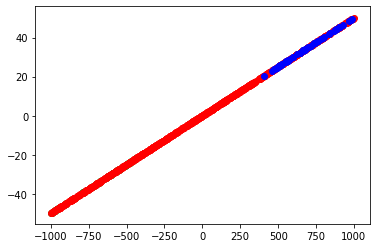

In [88]:
%matplotlib inline

classified_points = classify_points(points_4, 0.000000000001)
plotX = Plot([classified_points[0],classified_points[1],classified_points[2]])
plotX.draw()

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [89]:
classified_points = classify_points(points_4,0.000000000001, det_evaluator=numpy_det)

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Pod linią:  131
Na lini:  764
Nad linią:  105


b) macierz 3x3

Pod linią:  0
Na lini:  1000
Nad linią:  0


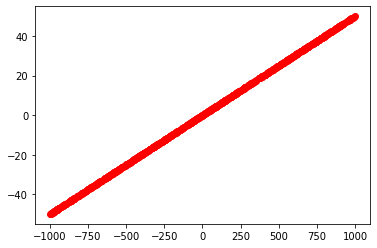

In [90]:
%matplotlib inline

classified_points = classify_points(points_4, 0.000000000001,generate_matrix_3x3)
plotX = Plot([classified_points[0],classified_points[1],classified_points[2]])
plotX.draw()

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [91]:
classified_points = classify_points(points_4,0.000000000001,generate_matrix_3x3, det_evaluator=numpy_det)

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Pod linią:  0
Na lini:  1000
Nad linią:  0


2. epsilon = 10^(-15)

a) macierz 2x2

Pod linią:  163
Na lini:  727
Nad linią:  110


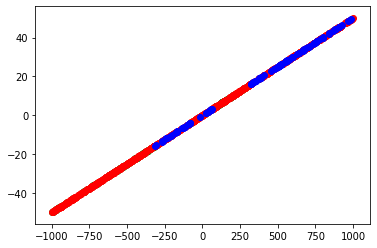

In [92]:
%matplotlib inline

classified_points = classify_points(points_4, 0.000000000000001)
plotX = Plot([classified_points[0],classified_points[1],classified_points[2]])
plotX.draw()

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [93]:
classified_points = classify_points(points_4,0.000000000000001, det_evaluator=numpy_det)

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Pod linią:  517
Na lini:  34
Nad linią:  449


b) macierz 3x3

Pod linią:  162
Na lini:  510
Nad linią:  328


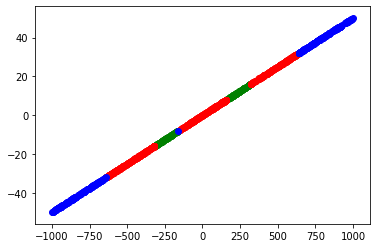

In [94]:
%matplotlib inline

classified_points = classify_points(points_4, 0.000000000000001,generate_matrix_3x3)
plotX = Plot([classified_points[0],classified_points[1],classified_points[2]])
plotX.draw()

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Dla wyznacznika liczonego funkcją z biblioteki numpy:

In [95]:
classified_points = classify_points(points_4,0.000000000000001,generate_matrix_3x3, det_evaluator=numpy_det)

print("Pod linią: ", len(classified_points[0].points))
print("Na lini: ", len(classified_points[1].points))
print("Nad linią: ", len(classified_points[2].points))

Pod linią:  322
Na lini:  278
Nad linią:  400
